# Imports and Data

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import scipy.interpolate as interpol
import statsmodels.api as sm
import pymannkendall as mk
import time
import copy
import math
import pickle


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

with open('unfiltered.pkl', 'rb') as handle:
    unfiltered = pickle.load(handle)
handle.close()

with open('../itdata/mtl_dffa15.pickle', 'rb') as handle:
    itdffa15 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_dffa30.pickle', 'rb') as handle:
    itdffa30 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_livesd.pickle', 'rb') as handle:
    itlives = pickle.load(handle)
    handle.close()
    
calls = {}
for c in ['uk', 'uk1', 'uk2', 'mit']:
    calls[c] = pc.apply_filters(unfiltered[c], 60)

globalt0 = dt.datetime.now()

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Fig 1 with resampling
The resampling is all about making all cohorts comparable.

In [2]:
with open('../itdata/tmp/mtl_dffa15.pickle', 'rb') as handle:
    tmpdff = pickle.load(handle)
    handle.close()
    
with open('../itdata/tmp/mtl_livesd.pickle', 'rb') as handle:
    tmplives = pickle.load(handle)
    handle.close()
    
pikachu = {}
for it in ['it1', 'it2']:
    pikachu[it] = {}
    for ego in tmpdff[it][60].keys():
        thekey = {"it1": "a", "it2": "b"}
        pikachu[it][f'{thekey[it]}{ego}'] = tmpdff[it][60][ego]
        pikachu['it'] = pikachu.get('it', {})
        pikachu['it'][f'{thekey[it]}{ego}'] = {}
        pikachu['it'][f'{thekey[it]}{ego}'].update(tmpdff[it][60][ego])

raichu = {}
for it in ['it1', 'it2']:
    raichu[it] = {}
    for ego in tmplives[it][60].keys():
        thekey = {"it1": "a", "it2": "b"}
        raichu[it][f'{thekey[it]}{ego}'] = tmplives[it][60][ego]
        raichu['it'] = raichu.get('it', {})
        raichu['it'][f'{thekey[it]}{ego}'] = {}
        raichu['it'][f'{thekey[it]}{ego}'].update(tmplives[it][60][ego])

In [3]:
lives = {}
forkey = {'uk1': 'a', 'uk2': 'b'}
for c in ['uk1', 'uk2', 'it1', 'it2', 'mit', 'it', 'uk']:
    if (c == 'it1') or (c == 'it2'):
        lives[c] = raichu[c]
        lives['all'] = lives.get('all', {})
        lives['all'].update(lives[c])
    elif c == 'it':
        lives[c] = raichu[c]
    elif c in ['uk1', 'uk2']:
        lf = pc.lives_dictionary(calls[c])
        for ego in lf.keys():
            for alter in lf[ego].keys():
                ell = lf[ego][alter]['ell']
                if ell > 300:
                    lf[ego][alter]['ell'] = 300
        lives[c] = {}
        for ego in lf.keys():
            thekey = f'{forkey[c]}{ego}'
            lives[c][thekey] = lf[ego]
        lives['all'] = lives.get('all', {})
        lives['all'].update(lives[c])
    elif c == 'uk':
        lives[c] = {}
        for u in ['uk1', 'uk2']:
            lives[c].update(lives[u])
    else:
        lives[c] = pc.lives_dictionary(calls[c])
        lives['all'] = lives.get('all', {})
        lives['all'].update(lives[c])

In [4]:
dffcomb = {}
for c in ['it', 'it1', 'it2']:
    dffcomb[c] = pikachu[c]

dffcomb['uk'] = {}
for c in ['uk1', 'uk2']:
    ddf = pc.get_f(calls[c], 'all', 15, 10)
    dffcomb[c] = {}
    forkey = {'uk1': 'a', 'uk2': 'b'}
    for ego in ddf.keys():
        dffcomb[c][f'{forkey[c]}{ego}'] = {}
        for alter in ddf[ego].keys():
            df1 = ddf[ego][alter]
            df2 = df1.loc[(df1['alpha'] <= 20)]
            dffcomb[c][f'{forkey[c]}{ego}'][alter] = df2
            dffcomb['uk'][f'{forkey[c]}{ego}'] = dffcomb['uk'].get(f'{forkey[c]}{ego}', {})
            dffcomb['uk'][f'{forkey[c]}{ego}'][alter] = dffcomb['uk'][f'{forkey[c]}{ego}'].get(alter, df2)
            
dffcomb['mit'] = pc.get_f(calls['mit'], 'all', 15, 10)

In [5]:
limits = [(0, 50), (100, 150), (220, 270)]

In [6]:
t0 = dt.datetime.now()

fig1 = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    fig1[c] = {}
    for i in range(3):
        fig1[c][i] = {}
        fig1[c][i]['f'] = pc.get_avgfa(dffcomb[c], lives[c], limits[i][0], limits[i][1])
        fig1[c][i]['fi'] = {}
        for ego in dffcomb[c].keys():
            tmp = {ego: dffcomb[c][ego]}
            fig1[c][i]['fi'][ego] = pc.get_avgfa(tmp, lives[c], limits[i][0], limits[i][1])
        
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.630763


In [8]:
dashed = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    dashed[c] = {}
    print(f'======================={c}=====================')
    for lamb in fig1[c].keys():
        if lamb >= 0:
            points = pc.get_b_slopes(fig1[c][lamb]['f'])
            dashed[c][lamb] = points
            print(f'\draw[dashed, {["charmander", "squirtle", "ekans"][lamb]}, ultra thick] (axis cs: {points[0][0]}, {points[1][0]}) -- (axis cs: {points[0][1]}, {points[1][1]});')

=======================uk=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.8944473463826683) -- (axis cs: 2, 0.8944473463826683);
\draw[dashed, squirtle, ultra thick] (axis cs: 2, 1.701645707584401) -- (axis cs: 7, 1.701645707584401);
\draw[dashed, ekans, ultra thick] (axis cs: 4, 2.881431126435454) -- (axis cs: 13, 2.881431126435454);
=======================uk2=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.6647318258067262) -- (axis cs: 2, 0.6647318258067262);
\draw[dashed, squirtle, ultra thick] (axis cs: 2, 1.5923360902462018) -- (axis cs: 7, 1.5923360902462018);
\draw[dashed, ekans, ultra thick] (axis cs: 3, 2.4509639574378883) -- (axis cs: 13, 2.4509639574378883);
=======================it=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.8442913094667548) -- (axis cs: 2, 0.8442913094667548);
\draw[dashed, squirtle, ultra thick] (axis cs: 2, 0.891389010039064) -- (axis cs: 8, 0.891389010039064);
\draw[

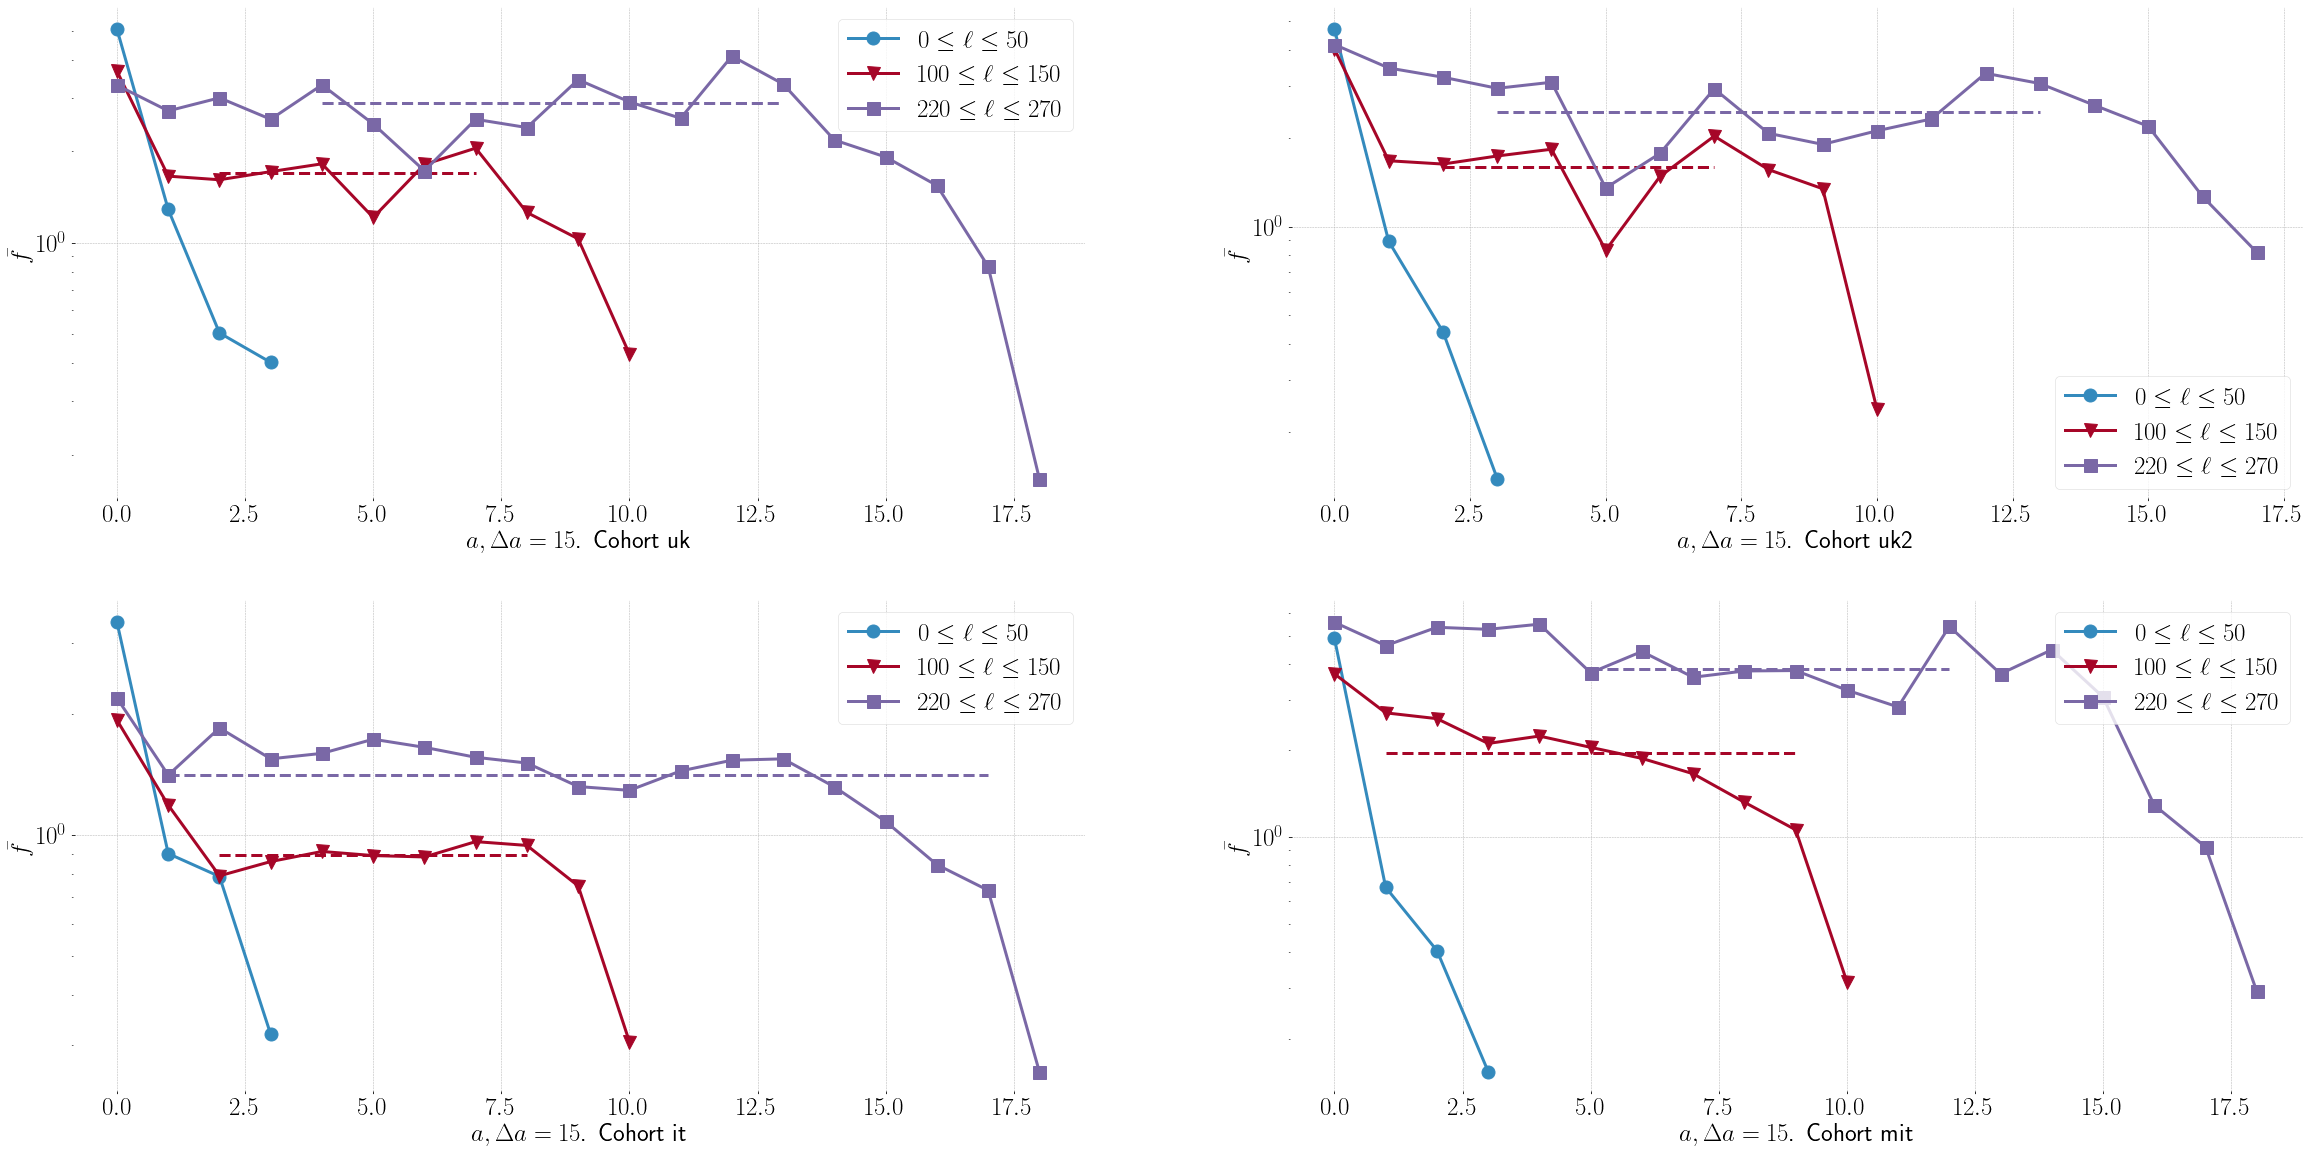

In [9]:
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2, 2, p)
    #plt.ylim(10**(-1), 10**1)
    plt.semilogy()
    #plt.xlim(-0.5, 26.5)
    plt.xlabel(fr'$a, \Delta a  = 15$. Cohort {c}')
    plt.ylabel(r'$\bar{f}$')
    for i in range(3):
        plt.plot(fig1[c][i]['f'].index, fig1[c][i]['f']['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${limits[i][0]}\leq \ell \leq {limits[i][1]}$')
        if i > 0:
            plt.plot(dashed[c][i][0], dashed[c][i][1], marker="", ls="--", lw=3, c=colors[i])
    plt.legend()
    p += 1
# plt.savefig("/home/vsvh/Desktop/B.png", dpi=200, pad_inches=2)

In [ ]:
# for c in fig1.keys():
#     tmp = pd.DataFrame()
#     for l in fig1[c].keys():
#         df = fig1[c][l]
#         df.columns = [f'l{int(l)}']
#         if len(tmp) == 0:
#             tmp = tmp.append(df)
#         else:
#             tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
#     tmp.index.rename('a', inplace=True)
#     tmp.fillna('nan', inplace=True)
#     tmp = tmp.loc[tmp.index < 13]
#     tmp.to_csv(f"../commpatterns/PNAS_paper/figs/fig1_{c}.dat", header=True, sep="\t")

# Fig 2

In [10]:
ksp = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    ksp[c] = {}
    series = fig1[c][1]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['m'] = ksp[c].get('m', [])
                ksp[c]['m'].append(stats.ks_2samp(left['f'], right['f'])[1])
    series = fig1[c][2]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['l'] = ksp[c].get('l', [])
                ksp[c]['l'].append(stats.ks_2samp(left['f'], right['f'])[1])

In [11]:
tmp = pd.DataFrame(index=range(111))
lists = []
for c in ksp.keys():
    for k in ['m', 'l']:
        thelist = ksp[c][k]
        lists.append(thelist)
        for i in range(len(thelist)):
            tmp.at[i, f'{c}{k}'] = thelist[i]

In [12]:
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/figs/fig2.dat", index=False, header=True, sep="\t")

In [15]:
def histogram(array, bins, log=True):
    xl = sorted(list(array))
    xo = xl[0]
    xf = xl[-1]
    if log:
        lmu = np.log10(xf / xo) / bins
        mu = 10**lmu
    dx = (xf - xo) / bins
    h = {}
    if log:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = np.log10(x / xo) // lmu
                h[i] = h.get(i, 0) + 1
    else:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = int((x - xo) // dx)
                h[i] = h.get(i, 0) + 1
    df = pd.DataFrame.from_dict(h, orient='index', columns=['h'])
    df['pmf'] = df['h'].div(sum(df['h']))
    for i in df.index:
        if log:
            df.at[i, 'label'] = xo*(mu**i)
        else:
            df.at[i, 'label'] = xo + (dx * (i))
    return df

In [14]:
bhist = {}
for c in fig1.keys():
    bhist[c] = {}
    for lamb in fig1[c].keys():
        bhist[c][lamb] = []
        for ego in fig1[c][lamb]['fi'].keys():
            curve = fig1[c][lamb]['fi'][ego]
            if len(curve > 1):
                b = pc.get_b_slopes(curve)
                if (b is not None) and (not pd.isna(b[1][1])):
                    bhist[c][lamb].append(b[1][1])

/Users/vsvh/Documents/research/comm_patterns_git/phonecalls.py:680: RuntimeWarning: invalid value encountered in double_scalars
  slope = (yf - yo) / (xf - xo)


In [20]:
cols = {1: 'm', 2: 'l'}
tmp = pd.DataFrame(index=range(111))
lists = []
for c in bhist.keys():
    for ell in [1, 2]:
        thelist = bhist[c][ell]
        for i in range(len(thelist)):
            tmp.at[i, f'{c}{cols[ell]}'] = thelist[i]
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/figs/fig2down.dat", index=False, header=True, sep="\t")

In [21]:
cols = ['ukm', 'uk2m', 'itm', 'mitm', 'ukl', 'uk2l', 'itl', 'mitl']
pos = [0,3,6,9,1,4,7,10]
tmp2 = pd.DataFrame({'c': cols, 'pos': pos})
idx = list(tmp2.index)
for i in idx:
    mean = np.mean(tmp[cols[i]].dropna())
    sem = np.std(tmp[cols[i]].dropna())
    tmp2.at[i, 'mean'] = mean
    tmp2.at[i, 'sem'] = sem
tmp2.index.name = 'idx'
a = tmp2.loc[tmp2.index < 4]
b = tmp2.loc[tmp2.index >= 4]
# a.to_csv("../commpatterns/PNAS_paper/figs/fig2bmdown.dat", index=True, header=True, sep="\t")
# b.to_csv("../commpatterns/PNAS_paper/figs/fig2bldown.dat", index=True, header=True, sep="\t")

In [22]:
dashed

{'uk': {0: [[1, 2], [0.8944473463826683, 0.8944473463826683]],
  1: [[2, 7], [1.701645707584401, 1.701645707584401]],
  2: [[4, 13], [2.881431126435454, 2.881431126435454]]},
 'uk2': {0: [[1, 2], [0.6647318258067262, 0.6647318258067262]],
  1: [[2, 7], [1.5923360902462018, 1.5923360902462018]],
  2: [[3, 13], [2.4509639574378883, 2.4509639574378883]]},
 'it': {0: [[1, 2], [0.8442913094667548, 0.8442913094667548]],
  1: [[2, 8], [0.891389010039064, 0.891389010039064]],
  2: [[1, 17], [1.4098818880803792, 1.4098818880803792]]},
 'mit': {0: [[1, 2], [0.536811285664926, 0.536811285664926]],
  1: [[1, 9], [1.9573264544906632, 1.9573264544906632]],
  2: [[5, 12], [3.8447671707204325, 3.8447671707204325]]}}

# Fig 3 with resampling

In [27]:
dffsurv = {}
dffsurv['all'] = {}
for c in dffcomb.keys():
    if c in ['it1', 'it2', 'uk1', 'uk2', 'mit']:
        dffsurv['all'].update(dffcomb[c])
    if c in ['uk', 'uk2', 'it', 'mit']:
        dffsurv[c] = dffcomb[c]

In [32]:
fig3 = {}
for c in dffsurv.keys():
    fig3[c] = pc.get_survival(dffsurv[c], alphafixed=(2,3), externalell=lives[c], lambdamax=27)

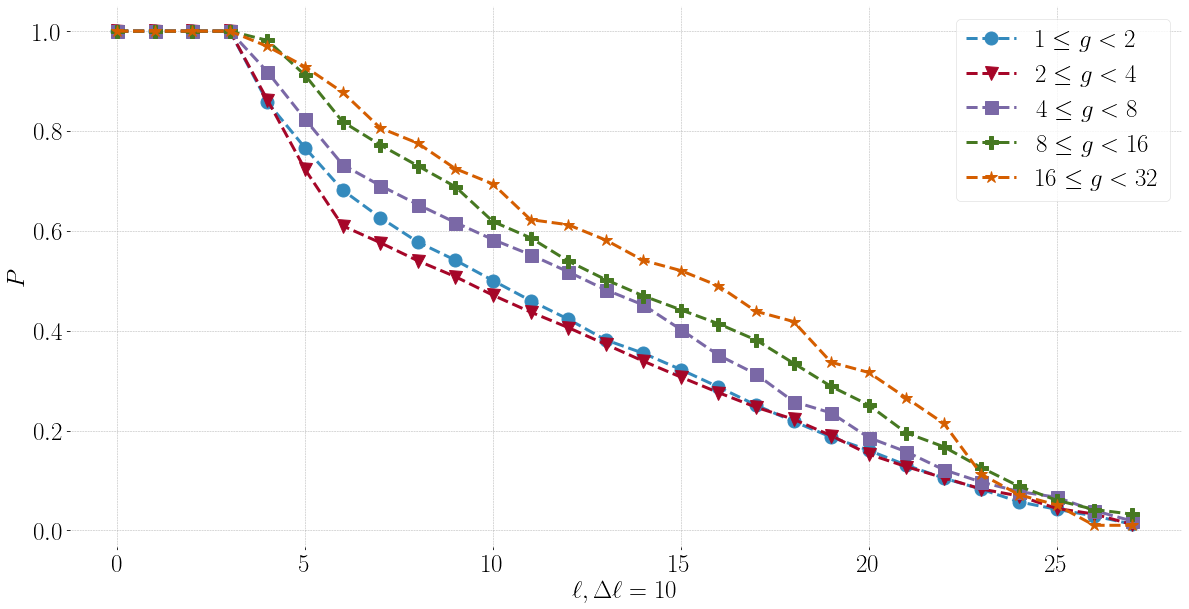

In [33]:
plt.xlabel(r'$\ell, \Delta \ell = 10$')
plt.ylabel(r'$P$')
for i in range(5):
    plt.plot(fig3['all'][i].index, fig3['all'][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${2**i} \leq g < {2**(i + 1)}$')
plt.legend()

In [34]:
tmp = pd.DataFrame({'lc': list(fig3['all'][0].index)})
for s in range(6):
    df = fig3['all'][s]
    tmp[f'p{int(s)}'] = df[0]
# tmp.to_csv(f'../commpatterns/PNAS_paper/figs/allsurvival.dat', header=True, index=False, sep="\t")

# Fig 4 with resampling

In [38]:
dffUM = {}
for c in ['uk', 'mit']:
    dffUM.update(dffsurv[c])
    
surv_cont = pc.get_survival(dffUM, lambdamax = 25, alphafixed=(2,3), externalell=lives['all'])

In [39]:
# tmp = pd.DataFrame()
# for s in range(6):
#     df = surv_cont[s].reset_index()
#     df.columns = ['lc', 'p']
#     df['lc'] *= 10
#     df['f'] = 2**s
#     ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
#     tmp = tmp.append(ttmmpp).reset_index(drop=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/figs/contour.dat", header=False, index=False, sep="\t")

In [40]:
points_it = pc.get_survival(dffsurv['it'], unbinned=True, lambdamax=25, alphafixed=(2,3), externalell=lives['all'])

tmp = pd.DataFrame()
for s in points_it.keys():
    if s <= 2**5 + 1:
        df = points_it[s].reset_index()
        df.columns = ['lc', 'p']
        df['lc'] *= 10
        df['f'] = s
        ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
        tmp = tmp.append(ttmmpp).reset_index(drop=True)
sub = [(i/4, (i + 1)/4) for i in range(4)]
p = 0
# for s in sub:
#     df = tmp.loc[(tmp['z'] > s[0]) & (tmp['z'] <= s[1])]
#     df = df.drop(columns='z')
#     df.to_csv(f'../commpatterns/PNAS_paper/figs/points{p}.dat', header=False, index=False, sep="\t")
#     print(s)
#     p += 1

(0.0, 0.25)
(0.25, 0.5)
(0.5, 0.75)
(0.75, 1.0)
